In [3]:
import os
import pandas as pd
import requests
import warnings
from pymatgen.core import Structure 
from typing import Dict, Optional

def parse_poscar_text_content(
    poscar_string_content: str,
    source_identifier: str = "N/A"
) -> Optional[Dict]:
    try:
        if not isinstance(poscar_string_content, str) or not poscar_string_content.strip():
            return None

        structure = Structure.from_str(poscar_string_content, fmt="poscar")

        comment_line = ""
        if poscar_string_content:
            lines = poscar_string_content.splitlines()
            if lines:
                comment_line = lines[0].strip()

        return {
            "source_identifier": source_identifier,
            "comment": comment_line,
            "formula": structure.composition.reduced_formula,
            "natoms": len(structure),
            "lattice_vectors": structure.lattice.matrix.tolist(),
            "sites": [{"species": site.species_string,
                       "xyz_frac": site.frac_coords.tolist(),
                       "xyz_cart": site.coords.tolist()}
                      for site in structure.sites],
            "selective_dynamics": None, 
            "velocities": None,       
            "pymatgen_structure": structure
        }
    except Exception as e:
        print(f"Error parsing POSCAR content from '{source_identifier}' using Structure.from_str: {e}")
        return None

def process_first_poscar_link_from_csv(
    csv_filepath: str,
    link_column_name: str = 'POSCAR_link',
    disable_ssl_verify: bool = False
) -> Optional[Dict]:
    if not os.path.exists(csv_filepath):
        print(f"Error: CSV file not found at '{csv_filepath}'")
        return None

    try:
        df = pd.read_csv(csv_filepath, nrows=1)
    except pd.errors.EmptyDataError:
        print(f"Error: CSV file '{csv_filepath}' is empty or has no data rows.")
        return None
    except Exception as e:
        print(f"Error reading CSV file '{csv_filepath}': {e}")
        return None

    if df.empty:
        print(f"Warning: No data rows found in CSV file '{csv_filepath}'.")
        return None

    if link_column_name not in df.columns:
        print(f"Error: Column '{link_column_name}' not found in the CSV file.")
        print(f"Available columns: {df.columns.tolist()}")
        return None

    poscar_url = df.iloc[0][link_column_name]

    if pd.isna(poscar_url) or not isinstance(poscar_url, str) or not poscar_url.strip():
        print(f"Error: URL in column '{link_column_name}' for the first row is missing, not a string, or empty.")
        return None

    print(f"Fetching POSCAR data from URL found in first row: {poscar_url}")

    requests_verify_param = True 
    if disable_ssl_verify:
        requests_verify_param = False
        warnings.warn(
            f"SSL certificate verification is disabled for fetching from {poscar_url}. "
            "This is insecure and should only be used if you trust the source and understand the risks.",
            UserWarning
        )

    try:
        # Suppress only the InsecureRequestWarning if verification is disabled
        if not requests_verify_param:
            from urllib3.exceptions import InsecureRequestWarning
            requests.packages.urllib3.disable_warnings(category=InsecureRequestWarning)
        
        response = requests.get(poscar_url, timeout=30, verify=requests_verify_param)
        response.raise_for_status() 
        poscar_text = response.text
    except requests.exceptions.SSLError as e:
        print(f"SSLError fetching content from URL '{poscar_url}': {e}")
        print("This might be due to issues with your system's SSL certificate authorities or the server's certificate.")
        print("You can try running the script with 'disable_ssl_for_url_fetch=True' in the main block (if applicable),")
        print("or try updating your system's CA certificates (e.g., `pip install --upgrade certifi`).")
        return None
    except requests.exceptions.RequestException as e:
        print(f"Error fetching content from URL '{poscar_url}': {e}")
        return None
    except Exception as e: 
        print(f"An unexpected error occurred while fetching from URL '{poscar_url}': {e}")
        return None

    if not poscar_text.strip():
        print(f"Warning: Content fetched from URL '{poscar_url}' is empty.")
        return None

    print(f"Successfully fetched content from {poscar_url}. Attempting to parse as POSCAR...")
    parsed_data = parse_poscar_text_content(poscar_text, source_identifier=poscar_url)

    return parsed_data


if __name__ == '__main__':
    your_local_csv_path = "/Users/abiralshakya/Downloads/materials_database.csv"
    link_column = 'POSCAR_link'

    disable_ssl_for_url_fetch = True # lol

    if your_local_csv_path == "path/to/your/local/file.csv" or not os.path.exists(your_local_csv_path):
        print(f"Please update the 'your_local_csv_path' variable in the script (currently: '{your_local_csv_path}') with the correct path to your .csv file.")
        print("Script will exit as a valid CSV path is not provided.")
    else:
        print(f"--- Processing CSV file: '{your_local_csv_path}' ---")
        print(f"--- Target column for POSCAR URLs: '{link_column}' ---")
        if disable_ssl_for_url_fetch:
            print("--- SSL VERIFICATION FOR URL FETCHING IS DISABLED ---")

        extracted_poscar_data = process_first_poscar_link_from_csv(
            your_local_csv_path,
            link_column_name=link_column,
            disable_ssl_verify=disable_ssl_for_url_fetch 
        )

        if extracted_poscar_data:
            print("\n--- Successfully Extracted and Parsed POSCAR Data from First Row's Link ---")
            print(f"Source URL: {extracted_poscar_data['source_identifier']}")
            print(f"Comment: {extracted_poscar_data['comment']}")
            print(f"Formula: {extracted_poscar_data['formula']}")
            print(f"Number of atoms: {extracted_poscar_data['natoms']}")
            if extracted_poscar_data['sites']:
                 print(f"First site: {extracted_poscar_data['sites'][0]['species']} @ {extracted_poscar_data['sites'][0]['xyz_frac']}")
            else:
                print("Sites: No site data found/parsed.")
            print(f"Selective Dynamics: {extracted_poscar_data.get('selective_dynamics', 'Not reliably parsed by this method')}")
            print(f"Velocities: {extracted_poscar_data.get('velocities', 'Not reliably parsed by this method')}")
            print(f"Pymatgen Structure: {extracted_poscar_data['pymatgen_structure']}")
        else:
            print("\nNo POSCAR data was extracted or an error occurred during processing the first row's link.")

--- Processing CSV file: '/Users/abiralshakya/Downloads/materials_database.csv' ---
--- Target column for POSCAR URLs: 'POSCAR_link' ---
--- SSL VERIFICATION FOR URL FETCHING IS DISABLED ---
Fetching POSCAR data from URL found in first row: https://www.topologicalquantumchemistry.com/data/nonalloycompounds/SG-165/Mat-3/POSCAR


/var/folders/sb/srkfc7tj3319314qk68v5cch0000gn/T/ipykernel_38306/2812386379.py:80: UserWarning: SSL certificate verification is disabled for fetching from https://www.topologicalquantumchemistry.com/data/nonalloycompounds/SG-165/Mat-3/POSCAR. This is insecure and should only be used if you trust the source and understand the risks.
  warnings.warn(


Successfully fetched content from https://www.topologicalquantumchemistry.com/data/nonalloycompounds/SG-165/Mat-3/POSCAR. Attempting to parse as POSCAR...

--- Successfully Extracted and Parsed POSCAR Data from First Row's Link ---
Source URL: https://www.topologicalquantumchemistry.com/data/nonalloycompounds/SG-165/Mat-3/POSCAR
Comment: generated by phonopy
Formula: LaF3
Number of atoms: 24
First site: La @ [0.6609000000000003, 0.0, 0.25]
Selective Dynamics: None
Velocities: None
Pymatgen Structure: Full Formula (La6 F18)
Reduced Formula: LaF3
abc   :   7.185000   7.185000   7.351000
angles:  90.000000  90.000000 120.000000
pbc   :       True       True       True
Sites (24)
  #  SP           a         b       c
---  ----  --------  --------  ------
  0  La    0.6609    0         0.25
  1  La    0.3391    0.3391    0.25
  2  La    0         0.6609    0.25
  3  La    0.6609    0.6609    0.75
  4  La    0         0.3391    0.75
  5  La    0.3391    0         0.75
  6  F     0.3127    0.

--- Processing CSV file: '/Users/abiralshakya/Downloads/materials_database.csv' ---
--- Target column for POSCAR URLs: 'POSCAR_link' ---
--- SSL VERIFICATION FOR URL FETCHING IS DISABLED ---
Fetching POSCAR data from URL found in first row: https://www.topologicalquantumchemistry.com/data/nonalloycompounds/SG-165/Mat-3/POSCAR


/var/folders/sb/srkfc7tj3319314qk68v5cch0000gn/T/ipykernel_38306/3395022836.py:103: UserWarning: SSL certificate verification is disabled for fetching from https://www.topologicalquantumchemistry.com/data/nonalloycompounds/SG-165/Mat-3/POSCAR. This is insecure and should only be used if you trust the source and understand the risks.
  warnings.warn(


Successfully fetched content from https://www.topologicalquantumchemistry.com/data/nonalloycompounds/SG-165/Mat-3/POSCAR. Attempting to parse as POSCAR...

--- Successfully Extracted and Parsed POSCAR Data from First Row's Link ---
Source URL: https://www.topologicalquantumchemistry.com/data/nonalloycompounds/SG-165/Mat-3/POSCAR
Comment: generated by phonopy
Formula: LaF3
Number of atoms: 24
First site: La @ [0.6609000000000003, 0.0, 0.25]
Selective Dynamics: None
Velocities: None
Pymatgen Structure: Full Formula (La6 F18)
Reduced Formula: LaF3
abc   :   7.185000   7.185000   7.351000
angles:  90.000000  90.000000 120.000000
pbc   :       True       True       True
Sites (24)
  #  SP           a         b       c
---  ----  --------  --------  ------
  0  La    0.6609    0         0.25
  1  La    0.3391    0.3391    0.25
  2  La    0         0.6609    0.25
  3  La    0.6609    0.6609    0.75
  4  La    0         0.3391    0.75
  5  La    0.3391    0         0.75
  6  F     0.3127    0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pymatgen/analysis/local_env.py:4022: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  r1 = _get_radius(structure[n])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pymatgen/analysis/local_env.py:4024: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  r2 = _get_radius(entry["site"])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pymatgen/analysis/local_env.py:3936: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  nn_data = self.get_nn_data(structure, n)


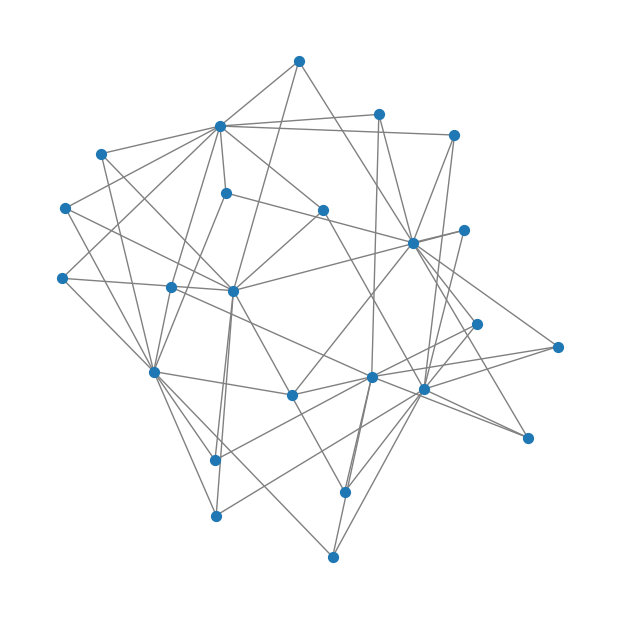

In [10]:
# script to get atomistic graph from materials_database.csv file

import os
import pandas as pd
import requests
import warnings
from pymatgen.core import Structure 
from typing import Dict, Optional
from jarvis.core.atoms import Atoms
#from jarvis.core.graphs import GraphGenerator
from pymatgen.analysis.local_env import CrystalNN
import networkx as nx
import matplotlib.pyplot as plt

def parse_poscar_text_content(
    poscar_string_content: str,
    source_identifier: str = "N/A"
) -> Optional[Dict]:
    try:
        if not isinstance(poscar_string_content, str) or not poscar_string_content.strip():
            return None

        structure = Structure.from_str(poscar_string_content, fmt="poscar")

        # jarvis_atoms = Atoms.from_dict(structure.as_dict())
        nn = CrystalNN()
        graph = {"nodes": [], "edges": []}


        for i, site in enumerate(structure.sites):
            graph["nodes"].append({
                "id": i,
                "species": site.specie.symbol,
                "coords": site.coords.tolist(),
            })
            # edges
            for nbr in nn.get_nn_info(structure, i):
                graph["edges"].append((i, nbr["site_index"], {"distance": nbr["weight"]}))

        comment_line = ""
        if poscar_string_content:
            lines = poscar_string_content.splitlines()
            if lines:
                comment_line = lines[0].strip()

        return {
            "source_identifier": source_identifier,
            "comment": comment_line,
            "formula": structure.composition.reduced_formula,
            "natoms": len(structure),
            "lattice_vectors": structure.lattice.matrix.tolist(),
            "sites": [{"species": site.species_string,
                       "xyz_frac": site.frac_coords.tolist(),
                       "xyz_cart": site.coords.tolist()}
                      for site in structure.sites],
            "selective_dynamics": None, 
            "velocities": None,       
            "pymatgen_structure": structure,
            "atomistic_graph": graph
        }
    except Exception as e:
        print(f"Error parsing POSCAR content from '{source_identifier}' using Structure.from_str: {e}")
        return None

def process_first_poscar_link_from_csv(
    csv_filepath: str,
    link_column_name: str = 'POSCAR_link',
    disable_ssl_verify: bool = False
) -> Optional[Dict]:
    if not os.path.exists(csv_filepath):
        print(f"Error: CSV file not found at '{csv_filepath}'")
        return None

    try:
        df = pd.read_csv(csv_filepath, nrows=1)
    except pd.errors.EmptyDataError:
        print(f"Error: CSV file '{csv_filepath}' is empty or has no data rows.")
        return None
    except Exception as e:
        print(f"Error reading CSV file '{csv_filepath}': {e}")
        return None

    if df.empty:
        print(f"Warning: No data rows found in CSV file '{csv_filepath}'.")
        return None

    if link_column_name not in df.columns:
        print(f"Error: Column '{link_column_name}' not found in the CSV file.")
        print(f"Available columns: {df.columns.tolist()}")
        return None

    poscar_url = df.iloc[0][link_column_name]

    if pd.isna(poscar_url) or not isinstance(poscar_url, str) or not poscar_url.strip():
        print(f"Error: URL in column '{link_column_name}' for the first row is missing, not a string, or empty.")
        return None

    print(f"Fetching POSCAR data from URL found in first row: {poscar_url}")

    requests_verify_param = True 
    if disable_ssl_verify:
        requests_verify_param = False
        warnings.warn(
            f"SSL certificate verification is disabled for fetching from {poscar_url}. "
            "This is insecure and should only be used if you trust the source and understand the risks.",
            UserWarning
        )

    try:
        # Suppress only the InsecureRequestWarning if verification is disabled
        if not requests_verify_param:
            from urllib3.exceptions import InsecureRequestWarning
            requests.packages.urllib3.disable_warnings(category=InsecureRequestWarning)
        
        response = requests.get(poscar_url, timeout=30, verify=requests_verify_param)
        response.raise_for_status() 
        poscar_text = response.text
    except requests.exceptions.SSLError as e:
        print(f"SSLError fetching content from URL '{poscar_url}': {e}")
        print("This might be due to issues with your system's SSL certificate authorities or the server's certificate.")
        print("You can try running the script with 'disable_ssl_for_url_fetch=True' in the main block (if applicable),")
        print("or try updating your system's CA certificates (e.g., `pip install --upgrade certifi`).")
        return None
    except requests.exceptions.RequestException as e:
        print(f"Error fetching content from URL '{poscar_url}': {e}")
        return None
    except Exception as e: 
        print(f"An unexpected error occurred while fetching from URL '{poscar_url}': {e}")
        return None

    if not poscar_text.strip():
        print(f"Warning: Content fetched from URL '{poscar_url}' is empty.")
        return None

    print(f"Successfully fetched content from {poscar_url}. Attempting to parse as POSCAR...")
    parsed_data = parse_poscar_text_content(poscar_text, source_identifier=poscar_url)

    return parsed_data


if __name__ == '__main__':
    your_local_csv_path = "/Users/abiralshakya/Downloads/materials_database.csv"
    link_column = 'POSCAR_link'

    disable_ssl_for_url_fetch = True # lol

    if your_local_csv_path == "path/to/your/local/file.csv" or not os.path.exists(your_local_csv_path):
        print(f"Please update the 'your_local_csv_path' variable in the script (currently: '{your_local_csv_path}') with the correct path to your .csv file.")
        print("Script will exit as a valid CSV path is not provided.")
    else:
        print(f"--- Processing CSV file: '{your_local_csv_path}' ---")
        print(f"--- Target column for POSCAR URLs: '{link_column}' ---")
        if disable_ssl_for_url_fetch:
            print("--- SSL VERIFICATION FOR URL FETCHING IS DISABLED ---")

        extracted_poscar_data = process_first_poscar_link_from_csv(
            your_local_csv_path,
            link_column_name=link_column,
            disable_ssl_verify=disable_ssl_for_url_fetch 
        )

        if extracted_poscar_data:
            print("\n--- Successfully Extracted and Parsed POSCAR Data from First Row's Link ---")
            print(f"Source URL: {extracted_poscar_data['source_identifier']}")
            print(f"Comment: {extracted_poscar_data['comment']}")
            print(f"Formula: {extracted_poscar_data['formula']}")
            print(f"Number of atoms: {extracted_poscar_data['natoms']}")
            if extracted_poscar_data['sites']:
                 print(f"First site: {extracted_poscar_data['sites'][0]['species']} @ {extracted_poscar_data['sites'][0]['xyz_frac']}")
            else:
                print("Sites: No site data found/parsed.")
            print(f"Selective Dynamics: {extracted_poscar_data.get('selective_dynamics', 'Not reliably parsed by this method')}")
            print(f"Velocities: {extracted_poscar_data.get('velocities', 'Not reliably parsed by this method')}")
            print(f"Pymatgen Structure: {extracted_poscar_data['pymatgen_structure']}")
        else:
            print("\nNo POSCAR data was extracted or an error occurred during processing the first row's link.")
            
        graph_dict = extracted_poscar_data["atomistic_graph"]
        G = nx.Graph()

        for node in graph_dict["nodes"]:
            G.add_node(
                node["id"],
                species=node.get("species"),
                coords=node.get("coords")
            )

        for u, v, attrs in graph_dict["edges"]:
            G.add_edge(u, v, **attrs)
        plt.figure(figsize=(6,6))
        pos = nx.spring_layout(G, seed=42)
        nx.draw(
            G,
            pos,
            node_size=50,
            edge_color="gray",
            with_labels=False
        )
        plt.axis("off")
        plt.show()